Arbol de Desicion.

Arbol de Desición que 
nos ayudará a predecir quien será el próximo 
en llegar al número 1 en las listas de 
Billboard Hot 100

In [1]:
#importando librerías
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use("ggplot")
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
artist_billboard = pd.read_csv(r"artists_billboard_fix3.csv")
artist_billboard.shape

(635, 11)

In [3]:
artist_billboard.head(10)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0
5,5,Where Is At (Yep Yep),DUSTIN LYNCH,Upbeat,Medium Tempo,Traditional,Male,20140531,219.0,0,1990.0
6,6,Single Ladies (Put A Ring On It),BEYONCE,Cool,Slow Tempo,Urban,Female,20081213,43.0,1,1981.0
7,7,Me And My Broken Heart,RIXTON,Urgent,Fast Tempo,Pop,Male,20140412,557.0,0,1973.0
8,8,I Luh Ya Papi,JENNIFER LOPEZ featuring FRENCH MONTANA,Aggressive,Medium Tempo,Urban,Female,20140329,182.0,0,1969.0
9,9,Chocolate,THE 1975,Yearning,Medium Tempo,Alternative & Punk,Male,20140208,347.0,0,0.0


In [4]:
#La variable top contiene si llegaron al número 1 (1)
#o no (0). Exploremos los datos:
artist_billboard.groupby("top").size()

top
0    494
1    141
dtype: int64

/home/angel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


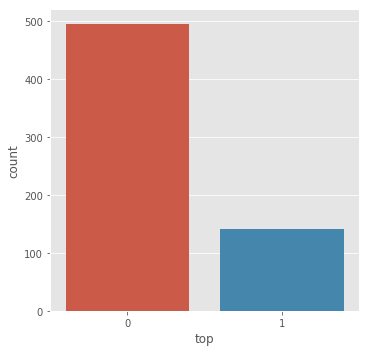

In [5]:
#Nuestra data está desbalanceada y esto
#tendrá una repercución
#por lo que tiene que corregirse
sb.factorplot("top",data=artist_billboard,kind="count")

/home/angel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/angel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/angel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `ca

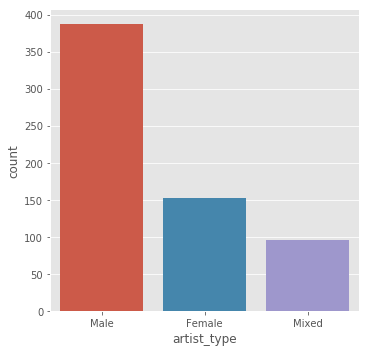

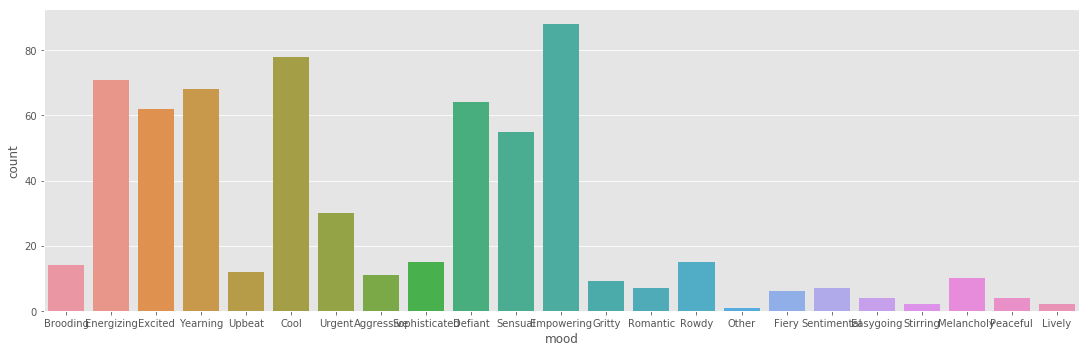

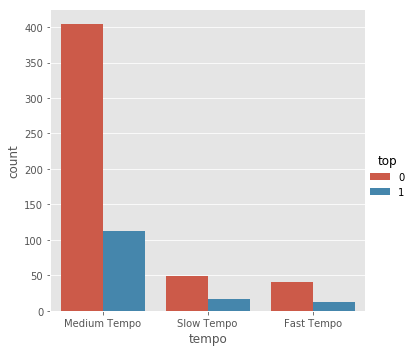

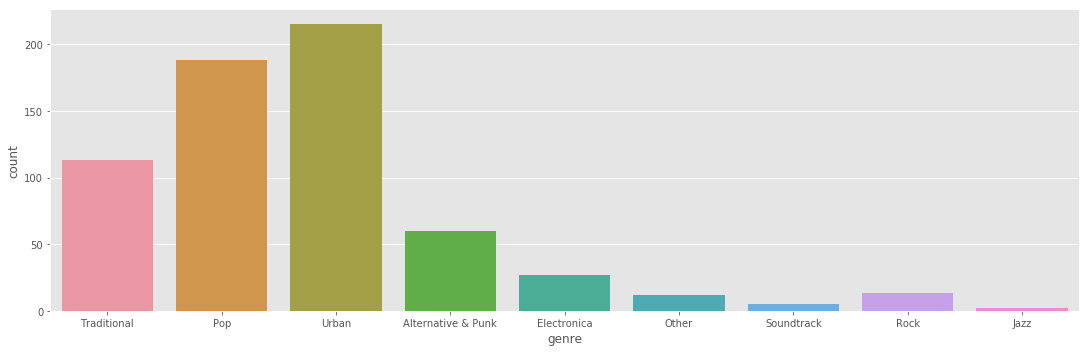

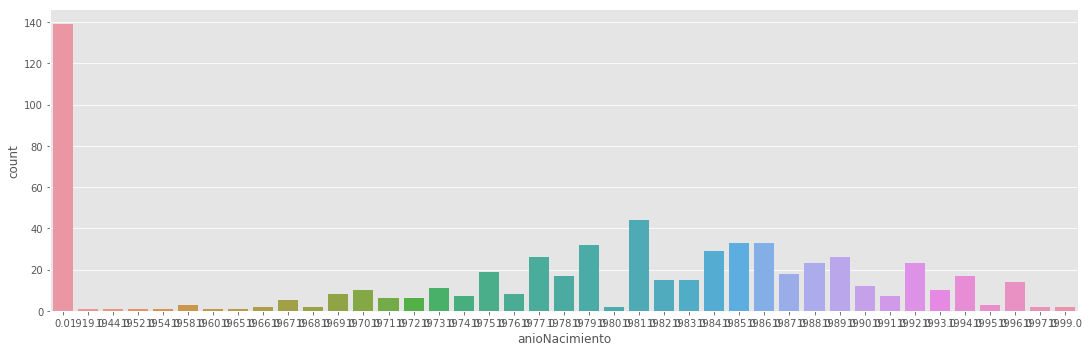

In [6]:
#Veamos los datos por tipo de artista, mood tempo y género
sb.factorplot("artist_type",data=artist_billboard,kind="count")
sb.factorplot("mood",data=artist_billboard,kind="count",aspect=3)
sb.factorplot("tempo",data=artist_billboard,hue="top",kind="count")
sb.factorplot("genre",data=artist_billboard,kind="count",aspect=3)
sb.factorplot("anioNacimiento",data=artist_billboard,kind="count",aspect=3)

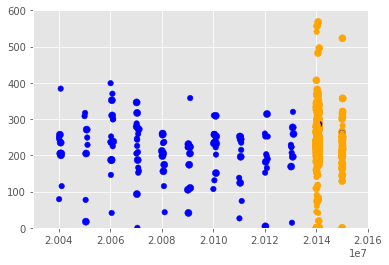

In [7]:
f1 = artist_billboard['chart_date'].values
f2 = artist_billboard['durationSeg'].values
 
colores = ['orange','blue']
tamanios = [30, 50]
asignar=[]
asignar2=[]
for index, row in artist_billboard.iterrows():    
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])
 
plt.scatter(f1, f2, c=asignar, s=tamanios)
plt.axis([20030101,20160101,0,600])
plt.show()

In [8]:
#Limpiemos nuestra data de artistas sin año de 
#nacimiento, les agregaremos valor nulo 
# a los que tienen 0

def edad_fix(anio):
    if anio==0:
        return None
    return anio
 
artist_billboard['anioNacimiento']=artist_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

#Ahora calculemos edades
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio
 
artist_billboard['edad_en_billboard']=artist_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);



In [9]:
#Ahora asignemos edades aleatorias 
#a los faltantes con la media y 
#desviación estándar de los datos

prom_edad = artist_billboard['edad_en_billboard'].mean()
sd_edad = artist_billboard['edad_en_billboard'].std()

num_edad_nula = artist_billboard['edad_en_billboard'].isnull().sum()
edad_nula_random = np.random.randint(prom_edad - sd_edad,prom_edad + sd_edad, size=num_edad_nula)

val_nulos = np.isnan(artist_billboard['edad_en_billboard'])

artist_billboard.loc[np.isnan(artist_billboard['edad_en_billboard']),'edad_en_billboard'] = edad_nula_random
artist_billboard['edad_en_billboard'] = artist_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " +str(prom_edad))
print("Desv Est: " + str(sd_edad))
print("Intervalo: [" +str(prom_edad - sd_edad)+","+str(prom_edad+sd_edad)+"]")

Edad Promedio: 30.10282258064516
Desv Est: 8.400788328615128
Intervalo: [21.702034252030032,38.50361090926029]


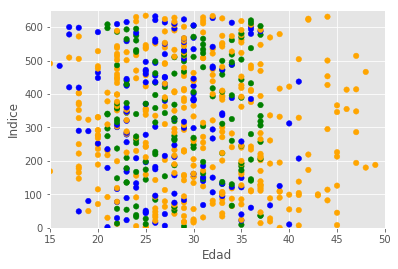

In [10]:
#Visualicemos los datos agregados en verde

f1 = artist_billboard['edad_en_billboard'].values
f2 = artist_billboard.index

colores = ['orange', 'blue', 'green']

asignar = []
for index, row in artist_billboard.iterrows():
    if(val_nulos[index]):
        asignar.append(colores[2]) #Verde
    else:
        asignar.append(colores[row['top']])
        
plt.scatter(f1,f2,c=asignar,s=30)
plt.xlabel("Edad")
plt.ylabel("Indice")
plt.axis([15,50,0,650])
plt.show()

In [14]:
#Transformemos datos numéricos en categoricos

#Mood
artist_billboard['moodEncoded'] = artist_billboard['mood'].map( {'Energizing': 6,
                                                               'Empowering': 6,
                                                               'Cool': 5,
                                                               'Yearning': 4,
                                                               'Excited': 5,
                                                               'Defiant': 3,
                                                               'Sensual': 2,
                                                               'Gritty': 3,
                                                               'Sophisticated': 4,
                                                               'Agressive': 4,
                                                               'Fiery': 4,
                                                               'Urgent': 3,
                                                               'Rowdy': 4,
                                                               'Sentimental': 4,
                                                               'Easygoing': 1,
                                                                'Melancholy': 4,
                                                                'Romantic': 2,
                                                                'Peaceful': 1,
                                                                'Brooding': 4,
                                                                'Upbeat': 5,
                                                                'Stirring': 5,
                                                                'Lively': 5,
                                                                'Other': 0,
                                                                 '': 0} ).astype(int)
#Tempo
artist_billboard['tempoEncoded'] = artist_billboard['tempo'].map({'Fast Tempo': 0,
                                                                 'Medium Tempo': 2,
                                                                 'Slow Tempo':1,
                                                                 '': 0}).astype(int)
#Genere
artist_billboard['genereEncoded'] = artist_billboard['genere'].map( {'Urban': 4,
                                                                    'Pop': 3,
                                                                    'Traditional': 2,
                                                                     'Alternative & Punk':1,
                                                                     'Electronica': 1,
                                                                     'Rock': 1,
                                                                     'Soundtrack': 0,
                                                                     'Jazz': 0,
                                                                     'Other': 0,
                                                                     '': 0}).astype(int)

#Artist Type

artist_billboard['artist_typeEncoded'] = artist_billboard['artist_type'].map( {'Female': 2,
                                                                              'Male': 3,
                                                                              'Mixed': 1,
                                                                              '': 0}).astype(int)

#Edad
artist_billboard.loc[artist_billboard['edad_en_billboard'] <=21, 'edadEncoded'] = 0
artist_billboard.loc[(artist_billboard['edad_en_billboard'] > 21 ) & (artist_billboard['edad_en_billboard'] <=26), 'edadEncoded'] = 1
artist_billboard.loc[(artist_billboard['edad_en_billboard'] > 26 ) & (artist_billboard['edad_en_billboard'] <=30), 'edadEncoded'] = 2
artist_billboard.loc[(artist_billboard['edad_en_billboard'] > 30 ) & (artist_billboard['edad_en_billboard'] <=40), 'edadEncoded'] = 3
artist_billboard.loc[artist_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

#Duración 
artist_billboard.loc[artist_billboard['durationSeg'] <=150, 'durationEncoded'] = 0
artist_billboard.loc[(artist_billboard['durationSeg'] > 150 ) & (artist_billboard['durationSeg'] <=180), 'durationEncoded'] = 1
artist_billboard.loc[(artist_billboard['durationSeg'] > 180 ) & (artist_billboard['durationSeg'] <=210), 'durationEncoded'] = 2
artist_billboard.loc[(artist_billboard['durationSeg'] > 210 ) & (artist_billboard['durationSeg'] <=240), 'durationEncoded'] = 3
artist_billboard.loc[(artist_billboard['durationSeg'] > 240 ) & (artist_billboard['durationSeg'] <=270), 'durationEncoded'] = 4
artist_billboard.loc[(artist_billboard['durationSeg'] > 270 ) & (artist_billboard['durationSeg'] <=300), 'durationEncoded'] = 5
artist_billboard.loc[artist_billboard['durationSeg'] > 300 , 'durationEncoded'] = 6


ValueError: Cannot convert non-finite values (NA or inf) to integer